## Setup

## Import Libraries

In [1]:
import os
import glob
import re
import json
import time
import pandas as pd

## Import Gemini

In [2]:
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

# Load API key securely
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GOOGLE_API_KEY")

# Configure Gemini
genai.configure(api_key=api_key)

# Set up Gemini Pro model
model = genai.GenerativeModel("models/gemini-2.0-flash")

## Import the Sagas Dataset
This dataset is from https://sagadb.org/ - format Text (UTF-8). For the current use case only the english translations of sagas (18) were included.

Sagas included:
- bandamanna_saga
- brennu-njals_saga
- egils_saga
- eiriks_saga_rauda
- eyrbyggja_saga
- faereyinga_saga
- gisla_saga_surssonar
- grettis_saga
- gunnlaugs_saga_ormstungu
- haensna-thoris_saga
- havardar_saga_isfirdings
- heidarviga_saga
- heidarviga_saga
- hrafnkels_saga_freysgoda
- kormaks_saga
- laxdaela_saga
- thordar_saga_hredu
- viga-glums_saga
- viglundar_saga

In [3]:
# Path to sagas dataset
SAGAS_PATH = "/kaggle/input/sagas-en/sagas_en"

# List all .txt files (sagas)
saga_files = sorted(glob.glob(f"{SAGAS_PATH}/*.txt"))
print(f"Found {len(saga_files)} saga files.")
print("\nExample file:", saga_files[0])

Found 18 saga files.

Example file: /kaggle/input/sagas-en/sagas_en/bandamanna_saga.en.txt


### Splitting the Sagas into Chapters for smaller chunks

In [4]:
def split_into_chapters(text):
    # Normalize line breaks
    text = text.replace('\r\n', '\n')

    # Match common chapter formats (case-insensitive)
    chapter_splits = re.split(r"(?:^|\n)(CHAPTER\s+\w+|Chapter\s+\d+|CHAP\.\s*\w+)(?=\s|\n)", text, flags=re.IGNORECASE)

    if len(chapter_splits) < 3:
        # Fallback: split by double newlines
        chunks = re.split(r'\n{2,}', text)
        return [{"chapter": f"Chunk {i+1}", "text": chunk.strip()} for i, chunk in enumerate(chunks) if chunk.strip()]

    chapters = []
    for i in range(1, len(chapter_splits), 2):
        heading = chapter_splits[i].strip()
        body = chapter_splits[i+1].strip()
        if body:
            chapters.append({"chapter": heading, "text": body})
    return chapters


In [5]:
all_chapters = []

for path in saga_files:
    saga_name = os.path.basename(path).replace(".en.txt", "").replace("_", " ").title()
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            text = f.read()
    except UnicodeDecodeError:
        print(f"⚠️ Skipping {saga_name} due to encoding issue.")
        continue

    chapters = split_into_chapters(text)
    for c in chapters:
        all_chapters.append({
            "saga": saga_name,
            "chapter": c["chapter"],
            "text": c["text"]
        })

print(f"✅ Extracted {len(all_chapters)} chapters from {len(saga_files)} sagas.")
print("📘 Example:", all_chapters[0]["saga"], "-", all_chapters[0]["chapter"])
print(all_chapters[0]["text"][:500])

✅ Extracted 790 chapters from 18 sagas.
📘 Example: Bandamanna Saga - Chapter 1
- Of Ufeig and Odd his son.

A man named Ufeig dwelt westaway in Midfirth, at a stead called Reeks: he was the son of Skidi, and his mother was called Gunnlaug, whose mother was Jarngerd, daughter of Ufeig Jarngerdson, of the Skards in the north country. Ufeig was wedded to a woman called Thorgerdi daughter of Vali; she came of great kin, and was a stirring woman. Ufeig was a wise man, and full of good counsel; he was great-hearted in all wise, but unhandy at money-getting; great and wide lands 


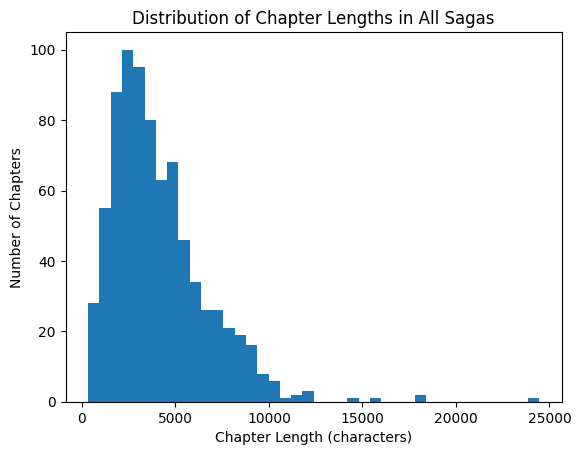

🔢 Max length: 24445
🔢 Median length: 3593
🔢 75th percentile: 5285


In [6]:
import matplotlib.pyplot as plt

chapter_lengths = [len(ch["text"]) for ch in all_chapters]

plt.hist(chapter_lengths, bins=40)
plt.xlabel("Chapter Length (characters)")
plt.ylabel("Number of Chapters")
plt.title("Distribution of Chapter Lengths in All Sagas")
plt.show()

print("🔢 Max length:", max(chapter_lengths))
print("🔢 Median length:", int(pd.Series(chapter_lengths).median()))
print("🔢 75th percentile:", int(pd.Series(chapter_lengths).quantile(0.75)))

In [7]:
def split_chapter_into_chunks(text, max_chars=6000):
    # Split by paragraphs and group until near max_chars
    paragraphs = text.split("\n\n")
    chunks = []
    current = ""

    for para in paragraphs:
        if len(current) + len(para) < max_chars:
            current += "\n\n" + para
        else:
            chunks.append(current.strip())
            current = para
    if current:
        chunks.append(current.strip())

    return chunks


In [8]:
chunk_counts = []
MAX_CHARS = 6000  # or whatever you're using

for chapter in all_chapters:
    chunks = split_chapter_into_chunks(chapter["text"], max_chars=MAX_CHARS)
    chunk_counts.append(len(chunks))

total_chunks = sum(chunk_counts)
print(f"📦 Total chunks across {len(all_chapters)} chapters: {total_chunks}")


📦 Total chunks across 790 chapters: 957


## # Step 1: Sanitize characters in saga_results
for result in saga_results:
    for char in result.get("result", {}).get("characters", []):
        sanitize_character(char)

# Step 2: Merge all sanitized characters
merged_chars = merge_characters_smart(
    [r["result"] for r in saga_results if "result" in r],
    verbose=False
)
Extracting Characters

In [61]:
import json

def build_character_extraction_prompt(chapter_text, saga_name, chapter_title):
    example_texts_outputs = [
        {
            "text": """Example 1:
A man named Ufeig dwelt westaway in Midfirth, at a stead called Reeks: he was the son of Skidi, and his mother was called Gunnlaug, whose mother was Jarngerd, daughter of Ufeig Jarngerdson. Ufeig was wedded to a woman called Thorgerdi daughter of Vali. Ufeig had a son by his wife named Odd. One named Vali also grew up in Ufeig's house. Ufeig was thingman of Styrmir.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Ufeig",
                        "patronym": "Skidison",
                        "gender": "male",
                        "nicknames": [],
                        "dwelling": ["Reeks", "Midfirth"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "husband", "with": "Thorgerdi" },
                            { "type": "father", "with": "Odd" },
                            { "type": "son", "with": "Skidi" },
                            { "type": "mother", "with": "Gunnlaug" },
                            { "type": "thingman of", "with": "Styrmir" }
                        ]
                    },
                    {
                        "first_name": "Thorgerdi",
                        "patronym": "Validottir",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "wife", "with": "Ufeig" },
                            { "type": "daughter", "with": "Vali" },
                            { "type": "mother", "with": "Odd" }
                        ]
                    },
                    {
                        "first_name": "Odd",
                        "patronym": "Ufeigson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "son", "with": "Ufeig" },
                            { "type": "son", "with": "Thorgerdi" }
                        ]
                    },
                    {
                        "first_name": "Vali",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Thorgerdi" },
                            { "type": "grew up in house of", "with": "Ufeig" }
                        ]
                    },
                    {
                        "first_name": "Skidi",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Ufeig" }
                        ]
                    },
                    {
                        "first_name": "Gunnlaug",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "mother", "with": "Ufeig" },
                            { "type": "daughter", "with": "Jarngerd" }
                        ]
                    },
                    {
                        "first_name": "Jarngerd",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "mother", "with": "Gunnlaug" },
                            { "type": "daughter", "with": "Ufeig Jarngerdson" }
                        ]
                    },
                    {
                        "first_name": "Ufeig Jarngerdson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Jarngerd" }
                        ]
                    },
                    {
                        "first_name": "Styrmir",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "chieftain of", "with": "Ufeig" }
                        ]
                    }
                ]
            }
        },
        {
            "text": """Example 2:
All this while nought had been heard of Uspak: a man named Mar married Swala; he was the son of Hildi; he took up his abode at Swalastead; a brother he had named Bialfi, half-witted, but a strong man. There was one named Bergthor, who dwelt at Bodvarsknolls: he had summed up the case when Uspak was outlawed; and so on an eve at Bodvarsknolls, when men were sitting by the fires, it fell out that one came and smote on the door and bade the master come out; but the master wotted that Uspak was come there, and said that he would nowise go out. Uspak egged him much thereto, but none the more would he go, and all others he forbade to stir abroad; so they two parted. But on the morrow when women came to the byre, lo! nine cows wounded to death. This was heard of far and wide. Again, as time wore on, it befell that a man came to Swalastead, and into the hall wherein slept Mar: that man went up to the bed, and thrust Mar through with a sax. It was Uspak, and he sang: Drew I new-grinded / Glaive from scabbard, / Against the maw / Of Mar I sped it... Even therewith, as he turned toward the door, up sprang Bialfi, and thrust at him with a whittle.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Uspak",
                        "gender": "male",
                        "chunk_mentions": 4,
                        "relationships": [
                            { "type": "killed", "with": "Mar" },
                            { "type": "enemy", "with": "Bialfi" },
                            { "type": "enemy", "with": "Bergthor" }
                        ]
                    },
                    {
                        "first_name": "Mar",
                        "patronym": "Hildison",
                        "gender": "male",
                        "dwelling": ["Swalastead"],
                        "chunk_mentions": 3,
                        "relationships": [
                            { "type": "husband", "with": "Swala" },
                            { "type": "son", "with": "Hildi" },
                            { "type": "brother", "with": "Bialfi" },
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    },
                    {
                        "first_name": "Swala",
                        "gender": "female",
                        "dwelling": ["Swalastead"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "wife", "with": "Mar" }
                        ]
                    },
                    {
                        "first_name": "Bialfi",
                        "gender": "male",
                        "chunk_mentions": 2,
                        "relationships": [
                            { "type": "brother", "with": "Mar" },
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    },
                    {
                        "first_name": "Hildi",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Mar" }
                        ]
                    },
                    {
                        "first_name": "Bergthor",
                        "gender": "male",
                        "dwelling": ["Bodvarsknolls"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    }
                ]
            }
        },
        {
            "text": """Example 3:
Odd abode at Mel till his old age, and was deemed a most noble man; from him are come the Midfirthers, Snorri Kalfson, and many other great men.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Odd",
                        "gender": "male",
                        "dwelling": ["Mel"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "ancestor", "with": "Snorri" }
                        ]
                    },
                    {
                        "first_name": "Snorri",
                        "patronym": "Kalfson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "descendant", "with": "Odd" }
                        ]
                    }
                ]
            }
        }
    ]

    example_blocks = "\n\n".join([
        f'Text:\n"""{ex["text"].strip()}"""\n\nOutput:\n{json.dumps(ex["output"], indent=2)}'
        for ex in example_texts_outputs
    ])

    prompt = f"""
You are analyzing a Norse saga titled "{saga_name}", chapter "{chapter_title}".

Your task is to extract all characters and their relationships in a structured JSON format with a top-level "characters" list.

For each character, include the following fields:

- "first_name": required
- "patronym": optional (e.g., "Thorvaldson", "Validottir")
- "gender": required — either "male" or "female"
- "nicknames": optional — list of nicknames (e.g., "the Wise"). Omit if none.
- "dwelling": optional — list of place names where the character resides or is from
- "chunk_mentions": number of times this person is named or referenced in this chunk
- "relationships": a list of relationships with other characters

⚠️ Important relationship rules:
- Use correct direction: e.g., if A is the son of B → A has {{ "type": "son", "with": "B" }}
- Only include relationships clearly stated in the text
- Do **not** guess or infer relationships or gender unless explicitly mentioned
- Use allowed types only

Allowed relationship types:
- son, daughter, father, mother
- husband, wife
- brother, sister
- ancestor, descendant
- thingman, chieftain of
- grew up in house of
- friend, rival, enemy
- servant of, master of
- killed (for murder or battle)

Here are several examples:

{example_blocks}

Now analyze this chapter:
\"\"\"{chapter_text[:6000]}\"\"\"
"""
    return prompt


In [62]:
import time
import json
from collections import defaultdict

def call_gemini_character_extraction(prompt):
    try:
        response = model.generate_content(prompt)
        raw = response.text
        json_start = raw.find('{')
        json_end = raw.rfind('}') + 1
        json_str = raw[json_start:json_end]
        return json.loads(json_str)
    except Exception as e:
        print("⚠️ Error parsing Gemini response:", e)
        return None

def fill_missing_characters(index):
    mentioned = set()
    for data in index.values():
        for rel in data["relationships"]:
            mentioned.add(rel["with"])
    for name in mentioned:
        if name not in index:
            index[name] = {
                "aliases": [],
                "mention_count": 0,
                "relationships": []
            }
    return index

def generate_character_id(first_name, patronym):
    return f"{first_name.lower()}_{patronym.lower()}" if patronym else f"{first_name.lower()}"

def merge_mentions(target, source):
    for scope in ["per_chunk", "per_chapter", "per_saga"]:
        if scope not in target:
            target[scope] = {}
        for k, v in source.get(scope, {}).items():
            target[scope][k] = target[scope].get(k, 0) + v
    return target

def merge_sources(existing_sources, new_sources):
    combined = existing_sources + [s for s in new_sources if s not in existing_sources]
    return combined
    
def create_field_sources(field, value, chunk_id):
    return {field: {value: [chunk_id]}} if value else {}

In [63]:
# Main processing
target_saga = "Bandamanna Saga"
saga_chapters = [c for c in all_chapters if c["saga"] == target_saga]
saga_results = []
global_character_index = {}

for i, chapter in enumerate(saga_chapters):
    chunks = split_chapter_into_chunks(chapter["text"], max_chars=6000)

    for j, chunk in enumerate(chunks):
        print(f"🔍 Processing {target_saga} - Chapter {i+1} - Chunk {j+1}/{len(chunks)}")
        chunk_id = f"{target_saga}_ch{i+1}_pt{j+1}"

        prompt = build_character_extraction_prompt(chunk, chapter["saga"], chapter["chapter"])
        result = call_gemini_character_extraction(prompt)

        if result:
            for char in result.get("characters", []):
                name = char["first_name"]
                patronym = char.get("patronym")
                char_id = generate_character_id(name, patronym)

                mentions = char.pop("chunk_mentions", 1)
                new_mentions = {
                    "per_chunk": {chunk_id: mentions},
                    "per_chapter": {chapter["chapter"]: mentions},
                    "per_saga": {target_saga: mentions}
                }

                sources = [{
                    "saga": target_saga,
                    "chapter": chapter["chapter"],
                    "chunk": chunk_id
                }]

                if char_id in global_character_index:
                    existing = global_character_index[char_id]
                    existing["mentions"] = merge_mentions(existing["mentions"], new_mentions)
                    existing["sources"] = merge_sources(existing["sources"], sources)
                    existing["relationships"].extend(char.get("relationships", []))
                    existing["relationships"] = list({
                        (r["type"], r["with"]): r for r in existing["relationships"]
                    }.values())
                else:
                    global_character_index[char_id] = {
                        "id": char_id,
                        "first_name": name,
                        "patronym": patronym,
                        "gender": char["gender"],
                        "nicknames": char.get("nicknames", []),
                        "dwelling": char.get("dwelling", []),
                        "mentions": new_mentions,
                        "sources": sources,
                        "relationships": char.get("relationships", []),
                        "aliases": [],
                        # "alias_of": None ← if relevant, see below
                    }

            saga_results.append({
                "id": chunk_id,
                "saga": target_saga,
                "chapter": chapter["chapter"],
                "chunk": j,
                "result": result
            })

        time.sleep(5)


🔍 Processing Bandamanna Saga - Chapter 1 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 2 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 3 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 4 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 5 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 6 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 7 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 8 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 9 - Chunk 1/2
🔍 Processing Bandamanna Saga - Chapter 9 - Chunk 2/2
🔍 Processing Bandamanna Saga - Chapter 10 - Chunk 1/2
🔍 Processing Bandamanna Saga - Chapter 10 - Chunk 2/2
🔍 Processing Bandamanna Saga - Chapter 11 - Chunk 1/3
🔍 Processing Bandamanna Saga - Chapter 11 - Chunk 2/3
🔍 Processing Bandamanna Saga - Chapter 11 - Chunk 3/3
🔍 Processing Bandamanna Saga - Chapter 12 - Chunk 1/1
🔍 Processing Bandamanna Saga - Chapter 13 - Chunk 1/1


In [64]:
import json
from pathlib import Path

def save_saga_results(saga_results, target_saga, overwrite=False):
    save_path = f"{target_saga.lower().replace(' ', '_')}_results.jsonl"
    new_count = 0

    if overwrite:
        # Overwrite entire file with current results
        with open(save_path, "w") as f:
            for entry in saga_results:
                f.write(json.dumps(entry) + "\n")
        new_count = len(saga_results)
        print(f"📝 Overwrote file with {new_count} results at {save_path}.")
    else:
        # Load existing IDs to avoid duplicates
        existing_ids = set()
        if Path(save_path).exists():
            with open(save_path, "r") as f:
                for line in f:
                    try:
                        entry = json.loads(line)
                        existing_ids.add(entry["id"])
                    except:
                        pass

        # Append only new results
        with open(save_path, "a") as f:
            for entry in saga_results:
                if entry["id"] not in existing_ids:
                    f.write(json.dumps(entry) + "\n")
                    new_count += 1

        print(f"✅ Appended {new_count} new chunk results to {save_path}.")

# Example usage:
# save_saga_results(saga_results, target_saga, overwrite=True)


# Overwrite everything
save_saga_results(saga_results, target_saga, overwrite=True)

# OR (default): append only new chunks
save_saga_results(saga_results, target_saga)


📝 Overwrote file with 17 results at bandamanna_saga_results.jsonl.
✅ Appended 0 new chunk results to bandamanna_saga_results.jsonl.


In [65]:
def count_chunks_for_saga(saga_name, max_chars=6000):
    saga_chapters = [c for c in all_chapters if c["saga"] == saga_name]
    total = 0
    for chapter in saga_chapters:
        total += len(split_chapter_into_chunks(chapter["text"], max_chars))
    return total
total_chunks = count_chunks_for_saga(target_saga)

print(f"📊 Total chunks for '{target_saga}': {total_chunks}")
print(f"🧱 Processed this run: {len(saga_results)}")
print(f"📦 Total in saved file: {len(existing_ids) + new_count}")

if (len(existing_ids) + new_count) == total_chunks:
    print("🎉 Full saga is now processed!")
else:
    print("⏳ Some chunks remain — re-run to complete.")


📊 Total chunks for 'Bandamanna Saga': 17
🧱 Processed this run: 17
📦 Total in saved file: 17
🎉 Full saga is now processed!


In [66]:
import json

saga_file = "bandamanna_saga_results.jsonl"

saga_results = []
with open(saga_file, "r") as f:
    for line in f:
        try:
            saga_results.append(json.loads(line))
        except json.JSONDecodeError:
            print("⚠️ Skipping invalid line")


In [79]:
import re
from collections import defaultdict

def clean_string(value):
    if not value:
        return None
    v = value.strip().lower()
    if v in {"none", "unknown", "undefined", "-", "—", "n/a", "na"}:
        return None
    return value.strip()

def normalize_name(name):
    return name.strip().title() if name else None

def normalize_patronym(patronym):
    if not patronym or patronym.strip().lower() in {"none", "unknown", ""}:
        return None
    return patronym.strip().lower()

def strip_patronym_suffix(patronym):
    if patronym:
        return re.sub(r'(son|sson|dottir)$', '', patronym.strip().lower())
    return None

def extract_parent_names(relationships):
    return {
        rel["with"].strip().lower()
        for rel in relationships
        if rel["type"] in {"father", "mother"}
    }

def have_conflicting_parents(rel1, rel2):
    p1 = extract_parent_names(rel1)
    p2 = extract_parent_names(rel2)

    # If either has no known parents → no conflict
    if not p1 or not p2:
        return False

    # Conflict only if both have different, non-overlapping parent names
    return not p1.issuperset(p2) and not p2.issuperset(p1) and not p1.intersection(p2)


def has_shared_nickname(nick1, nick2):
    s1 = set(nick1 if isinstance(nick1, list) else [nick1]) if nick1 else set()
    s2 = set(nick2 if isinstance(nick2, list) else [nick2]) if nick2 else set()
    return bool(s1.intersection(s2))

def sanitize_character(char):
    char["first_name"] = normalize_name(char.get("first_name"))
    char["patronym"] = normalize_patronym(char.get("patronym"))
    
    if "nicknames" in char:
        nicks = char["nicknames"]
        if isinstance(nicks, str):
            nicks = [nicks]
        char["nicknames"] = [clean_string(n).title() for n in nicks if clean_string(n)]
        if not char["nicknames"]:
            del char["nicknames"]

    if "dwelling" in char:
        char["dwelling"] = [clean_string(d).title() for d in char["dwelling"] if clean_string(d)]

    if "relationships" in char:
        cleaned_rels = []
        seen = set()
        for rel in char["relationships"]:
            rel_type = clean_string(rel.get("type"))
            rel_with = clean_string(rel.get("with"))
            if rel_type and rel_with:
                key = (rel_type, rel_with.lower())
                if key not in seen:
                    seen.add(key)
                    cleaned_rels.append({"type": rel_type, "with": rel_with})
        char["relationships"] = cleaned_rels

    return char

def can_merge(a, b, verbose=False):
    name_a = normalize_name(a["first_name"])
    name_b = normalize_name(b["first_name"])
    if name_a != name_b:
        if verbose:
            print(f"❌ Different names: '{name_a}' vs '{name_b}'")
        return False

    # Patronym check
    pa = a.get("patronym")
    pb = b.get("patronym")
    pa_norm = normalize_patronym(pa)
    pb_norm = normalize_patronym(pb)

    if pa_norm and pb_norm and pa_norm != pb_norm:
        if verbose:
            print(f"❌ Patronym mismatch: {pa_norm} vs {pb_norm}")
        return False
    patronym_ok = (pa_norm == pb_norm) or (not pa_norm or not pb_norm)

    if have_conflicting_parents(a.get("relationships", []), b.get("relationships", [])):
        if verbose:
            print(f"❌ Conflicting parents: {a['first_name']} and {b['first_name']}")
        return False

    if has_shared_nickname(a.get("nicknames"), b.get("nicknames")):
        if verbose:
            print(f"✅ Shared nickname → merge: {a['first_name']}")
        return True

    pa_base = strip_patronym_suffix(pa)
    pb_base = strip_patronym_suffix(pb)
    parents_a = extract_parent_names(a.get("relationships", []))
    parents_b = extract_parent_names(b.get("relationships", []))

    if pa_base and (pa_base in parents_a or pa_base in parents_b):
        if verbose:
            print(f"✅ Patronym base matches parent → merge: {a['first_name']}")
        return True
    if pb_base and (pb_base in parents_a or pb_base in parents_b):
        if verbose:
            print(f"✅ Patronym base matches parent → merge: {b['first_name']}")
        return True

    if patronym_ok:
        if verbose:
            print(f"✅ Fallback: name + patronym OK → merge: {a['first_name']}")
        return True

    if verbose:
        print(f"🚫 Not merging '{a['first_name']}' ({pa}) with '{b['first_name']}' ({pb}) — no condition satisfied")
    return False



def merge_two_characters(a, b):
    merged = {
        "first_name": normalize_name(a["first_name"]),
        "patronym": a.get("patronym") or b.get("patronym"),
        "chunk_mentions": a.get("chunk_mentions", 0) + b.get("chunk_mentions", 0),
        "nicknames": list(set(
            (a.get("nicknames") if isinstance(a.get("nicknames"), list) else [a.get("nicknames")] if a.get("nicknames") else []) +
            (b.get("nicknames") if isinstance(b.get("nicknames"), list) else [b.get("nicknames")] if b.get("nicknames") else [])
        )),
        "relationships": []
    }

    existing = set()
    for rel in a.get("relationships", []) + b.get("relationships", []):
        rel_key = (rel["type"], rel["with"])
        if rel_key not in existing:
            merged["relationships"].append(rel)
            existing.add(rel_key)

    if not merged["nicknames"]:
        del merged["nicknames"]
    return merged

def merge_characters_smart(results, verbose=True):
    merged_index = []

    for result in results:
        for char in result.get("characters", []):
            matched = False
            for i, existing in enumerate(merged_index):
                if can_merge(existing, char, verbose=verbose):
                    if verbose:
                        print(f"🧱 Merging '{char['first_name']}' ({char.get('patronym')}) with '{existing['first_name']}' ({existing.get('patronym')})")
                    merged_index[i] = merge_two_characters(existing, char)
                    matched = True
                    break
            if not matched:
                merged_index.append(char)

    return merged_index


In [83]:
# Step 1: Sanitize characters in saga_results
for result in saga_results:
    for char in result.get("result", {}).get("characters", []):
        sanitize_character(char)

# Step 2: Merge all sanitized characters
merged_chars = merge_characters_smart(
    [r["result"] for r in saga_results if "result" in r],
    verbose=False
)


In [84]:
# Step: Inspect results
for char in merged_chars:
    print(f"🧙 {char['first_name']}" + (f" ({char['patronym']})" if char.get("patronym") else ""))
    if "nicknames" in char:
        print(f"  🧢 Nicknames: {', '.join(char['nicknames'])}")
    print(f"  🔢 Mentions: {char['chunk_mentions']}")
    print(f"  🤝 Relationships:")
    for rel in char["relationships"]:
        print(f"    - {rel['type']} → {rel['with']}")
    print()


🧙 Ufeig (skidison)
  🧢 Nicknames: Old, Old Carle, The Wise
  🔢 Mentions: 0
  🤝 Relationships:
    - son → Skidi
    - mother → Gunnlaug
    - husband → Thorgerdi
    - father → Odd
    - thingman of → Styrmir
    - father → Jarngerd
    - friend → Egil
    - friend → Gellir
    - son → Odd

🧙 Odd (ufeigson)
  🔢 Mentions: 0
  🤝 Relationships:
    - son → Ufeig
    - son → Thorgerdi
    - enemy → Uspak
    - father → Uspak
    - chieftain of → thingmen
    - friend → Uspak
    - kinsman → Vali
    - son → Odd's father
    - rival → Uspak
    - friend → Vali
    - enemy → Styrmir
    - enemy → Thorarin
    - enemy → Hermund
    - enemy → Gellir
    - enemy → Egil
    - enemy → Jarnskeggi
    - enemy → Skeggbroddi
    - enemy → Thor-geir
    - husband → Odd's wife
    - ancestor → Snorri

🧙 Thorgerdi (validottir)


KeyError: 'chunk_mentions'

In [70]:
from collections import defaultdict

# Map of first_name → list of merged characters
merged_by_name = defaultdict(list)

for char in merged_chars:
    first = char.get("first_name", "").strip().title()
    merged_by_name[first].append(char)

# Show only names that appear more than once (i.e. not merged)
print("📌 Merged characters with duplicate first names:\n")

for name, chars in merged_by_name.items():
    if len(chars) > 1:
        print(f"🧙 {name} — {len(chars)} distinct merged entries")
        for i, entry in enumerate(chars, 1):
            pat = entry.get("patronym", "—")
            nicks = ", ".join(entry.get("nicknames", [])) if "nicknames" in entry else "—"
            print(f"  [{i}] Patronym: {pat}, Nicknames: {nicks}, Mentions: {entry['chunk_mentions']}")
        print()


📌 Merged characters with duplicate first names:

🧙 Odd — 4 distinct merged entries
  [1] Patronym: Ufeigson, Nicknames: —, Mentions: 38
  [2] Patronym: —, Nicknames: —, Mentions: 1
  [3] Patronym: None, Nicknames: —, Mentions: 2
  [4] Patronym: —, Nicknames: —, Mentions: 1



In [71]:
for i, r in enumerate(saga_results):
    for char in r["result"].get("characters", []):
        if char["first_name"].strip().lower() == "odd":
            print(f"🔎 Found Odd in chunk {r['id']} (entry #{i})")
            print(f"  Patronym: {char.get('patronym', '—')}")
            print(f"  Mentions: {char.get('chunk_mentions', '—')}")
            father_rels = [rel for rel in char.get("relationships", []) if rel["type"] == "father"]
            if father_rels:
                for rel in father_rels:
                    print(f"  👨 Father → {rel['with']}")
            else:
                print("  👨 No father relationship found")
            print("—" * 50)


🔎 Found Odd in chunk Bandamanna Saga_ch1_pt1 (entry #0)
  Patronym: Ufeigson
  Mentions: —
  👨 No father relationship found
——————————————————————————————————————————————————
🔎 Found Odd in chunk Bandamanna Saga_ch2_pt1 (entry #1)
  Patronym: —
  Mentions: —
  👨 Father → Uspak
——————————————————————————————————————————————————
🔎 Found Odd in chunk Bandamanna Saga_ch3_pt1 (entry #2)
  Patronym: —
  Mentions: —
  👨 No father relationship found
——————————————————————————————————————————————————
🔎 Found Odd in chunk Bandamanna Saga_ch4_pt1 (entry #3)
  Patronym: —
  Mentions: —
  👨 No father relationship found
——————————————————————————————————————————————————
🔎 Found Odd in chunk Bandamanna Saga_ch5_pt1 (entry #4)
  Patronym: —
  Mentions: —
  👨 No father relationship found
——————————————————————————————————————————————————
🔎 Found Odd in chunk Bandamanna Saga_ch6_pt1 (entry #5)
  Patronym: —
  Mentions: —
  👨 No father relationship found
——————————————————————————————————————————————————